In [1]:
import pandas as pd
import numpy as np
import copy
import datetime
import time

/Users/annacjacobson/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
file = './TestData/tz_swahili.rttm'

### RTTM to Dataframe

In [3]:
# Step 1: Load the .rttm into a dataframe
def DfFromRttm(rttm):
    """ Given an RTTM file, parses it into a Pandas DataFrame.
    """
    df = pd.read_csv(rttm,
                     sep=' ',
                     names=['task','inputFile','one','start','duration',
                     'NA_1','NA_2','class','NA_3', 'NA_4'])    
    
    # Drop the columns we don't care about from a base RTTM
    vizframe = copy.deepcopy(df) \
        .drop(
        columns=[
            'task',
            'inputFile',
            'one',
            'NA_1',
            'NA_2',
            'NA_3',
            'NA_4'])
    
    return vizframe

## Audiozation Data

In [4]:
def RttmToUtteranceIndexedSpeakerActivity(df, outfile=None):
    """ Given an RTTM input file, generate a dataframe structured
        to support a visualization of type 'Speaker Activity' and optionally
        export to a csv located at {outfile}

        df = Pandas DataFrame containing a standard .rttm file
        outfile = destination for exported CSV (path, filename, extension)
    """

    # Check whether an outfile has been defined
    if outfile is not None:
        export = True
    else: 
        export = False

    # Drop the columns we don't care about from a base RTTM
    vizframe = copy.deepcopy(df) 

    # Rename columns for our viz's purposes
    vizframe = vizframe.rename(columns={
        'start': 'START',
        'duration': 'DUR',
        'class': 'LABEL'
    })

    # Remap the model classes for this viz's purposes
    vizframe['LABEL'] = vizframe['LABEL'].map({
        'KCHI': 'CHILD',
        'CHI': 'CHILD',
        'FEM': 'ADULT',
        'MAL': 'ADULT'
    })

    # Filter the dataframe to just the 'clean' (non-'SPEECH') classes
    vizframe = vizframe[vizframe['LABEL'].isin(['CHILD', 'ADULT'])]
    vizframe['LABEL_NUM'] = vizframe['LABEL'] \
        .apply(lambda x: 1 if x == 'CHILD'
               else (-1 if x == 'ADULT' else NaN))
    vizframe['DUR_TRANS'] = vizframe['LABEL_NUM'] * vizframe['DUR']
    vizframe['COUNT'] = 1

    if export:
        vizframe.to_csv(outfile)

    return vizframe

In [5]:
RttmToUtteranceIndexedSpeakerActivity(DfFromRttm(file), outfile=None)

,START,DUR,LABEL,LABEL_NUM,DUR_TRANS,COUNT
0,0.041,0.289,CHILD,1,0.289,1
1,11.148,1.549,CHILD,1,1.549,1
3,13.492,3.827,CHILD,1,3.827,1
5,20.183,0.132,CHILD,1,0.132,1
6,20.993,2.255,CHILD,1,2.255,1
...,...,...,...,...,...,...
369,1234.668,2.602,ADULT,-1,-2.602,1
370,1236.011,14.435,ADULT,-1,-14.435,1
371,1251.457,14.123,ADULT,-1,-14.123,1
372,1251.656,0.275,ADULT,-1,-0.275,1


## Time-Indexed Dataframe

In [6]:
## Identify the latest timestamp we need.
def GetLatestTimestampNeeded(input_df, verbose=True):
    """ Given an RTTM-derived dataframe,
        extract the last timestamp we'll need
        as a scalar. It will be the maximum value of
        the `start` + `duration` columns.
    """
    input_df['end_time'] = input_df['start'] + input_df['duration']
    end_row = input_df['end_time'].idxmax()
    latest_timestamp = input_df.at[end_row,'start'] + input_df.at[end_row,'duration']
    if verbose:
        print(f'''
        >> This DF has data that runs until {latest_timestamp}.
        >> That value was found at row {end_row} and is the sum of
           {input_df.at[end_row, 'start']} and {input_df.at[end_row, 'duration']}
        ''')
    return latest_timestamp

In [7]:
## Create millisecond index.
def MakeMillisecondIntegerIndexedDf(
        start,
        duration,
        colname='value',
        colvalue='',
        decimals=4,
        verbose=False):
    """ Create an integer-indexed dataframe covering a 
            {duration} from
            {start} having a single column with the name
            {colname} that contains a default value of
            {colvalue} for that named column.
        By default it runs quietly rather than {verbose}.
    """

    if verbose:
        print(f' >>> From [{start}] for [{duration}] seconds' \
              f' until [{start+duration}] the col [{colname}]' \
              f' will contain the value [{colvalue}]')
    
    # Create a range between the start and stop
    rng = pd.RangeIndex(start = int(round(start, decimals)*1000),
                        stop  = int(round(start+duration, decimals)*1000),
                        step  = 1)
    
    # Turn that series into a DataFrame and rename the index for clarity
    df = pd.Series(colvalue, index=rng).to_frame(name=colname)
    df.index.name=f'millisecond_ints'
    if verbose:
        print(df.head(3), df.tail(3))
    return df

In [8]:
## Subset by label.
def SubsetDfByLabel(df, column_list, key_col, value):
    """ Given a dataframe {df}, return the subset
        of the dataframe defined by {column_list}
        containing {value} in the {key_col} column
    """
    return df[df[key_col] == value][[x for x in column_list]]

In [9]:
# This is to make our lives easier later
ny_7759 = DfFromRttm(file)
ny_7759_bak = copy.deepcopy(ny_7759)

In [10]:
# This is to make our lives easier later
ny_0287 = DfFromRttm(file)
ny_0287_bak = copy.deepcopy(ny_0287)

In [11]:
def BuildOneHotEncodedDf(
    input_df,
    label_list=[],
    verbose=True
    ):
    """ Given an RTTM-generated DataFrame, generate a DF containing
        all of the labels of interest in one-hot encoded format
        against an integer-indexed DF representing milliseconds from
        the beginning of the recording
    """
    
    max_seconds_needed = GetLatestTimestampNeeded(input_df)
    if verbose:
        print(f'max_seconds_needed is equal to {max_seconds_needed}')

    outer_df = MakeMillisecondIntegerIndexedDf(
                start      = 0,
                duration   = max_seconds_needed,
                colname    = 'base_col',
                colvalue   = np.nan,
                decimals   = 4,
                verbose    = True)

    if verbose:
        print(f'The outer_df frame will contain {outer_df.shape[0]} records.')
    
    # Loop through labels, subsetting the original DF so
    # we can merge it back into the main outer DF
    for label in label_list:
        print(f'>>> Processing label: {label}\n')

        if label not in input_df['class'].unique():
            print(f'Label {label} not found in this dataset')
            label_base_df = pd.DataFrame(columns=[label])
            continue
        
        # Gotta avoid errors from accidentally manipulating original DFs
        temp_df = copy.deepcopy(input_df)

        # Replace the deep-copied DF with a subset of itself
        # that contains only records for the label of interest
        temp_df = SubsetDfByLabel(
            input_df,
            column_list = ['start', 'duration', 'class'],
            key_col     = 'class',
            value       = label
        )

        if verbose:
            print(f'The temp_df subset for label {label}' \
                  f' contains {temp_df.shape[0]} rows')
            print(temp_df.head(5),
                  temp_df.tail(5))
        
        # The subsetted DF retains the original index unless you reset it
        temp_df.reset_index(drop=True,
                            inplace=True)
        
        if verbose:
            print(f'The temp_df frame is as follows:\n{temp_df}')

        # Creating the base DF for this label - ranges from 0 to the earliest record
        label_base_df = MakeMillisecondIntegerIndexedDf(
                start      = 0,
                duration   = temp_df['start'].min(),
                colname    = label,
                colvalue   = np.nan,
                decimals   = 4,
                verbose    = verbose)
        
        if verbose:
            # The head() will always be the same, so we need to look at the tail() to verify
            print('\n>>> The last few rows of the label_base_df for label' \
                  f' {label} are:\n{label_base_df.tail()}' \
                  f'\n>>> Base DF size for label {label}: {len(temp_df)}\n')

        for i in temp_df.index:
            if verbose:
                print('*' * 10 + f'{label}: i = {i}' + '*' * 10)
            s, d, cn = temp_df.loc[i, ['start', 'duration', 'class']]
            label_base_df = label_base_df.append(
                MakeMillisecondIntegerIndexedDf(
                    start    = s,
                    duration = d,
                    colname  = cn,
                    colvalue = 1,
                    decimals = 4,
                    verbose  = verbose
                ))
            
            if verbose:
                print(f'\n>>> Base DF size after {i}' \
                      ' rounds: {len(label_base_df)}')
                print(f'\n>>> The head:\n{label_base_df.head(10)}'\
                      f'\n>>> The tail:\n{label_base_df.tail(10)}')
                print('\n>>> A few of its contents:'\
                      f'\n{label_base_df[~label_base_df[label].isna()].head(5)}')

        # Creating a placeholder for the update call
        outer_df[label] = np.nan
        
        # When attempting the update method:
        print(f'Attempting update with DF from label {label}')
        outer_df.update(
            other     = label_base_df,
            overwrite = True)
        
        if verbose:
            try:
                print(outer_df[~outer_df[label].isna()].head())
            except:
                print(outer_df)
            
    return outer_df

In [12]:
tester = DfFromRttm(file)
labels = ['MAL', 'CHI', 'KCHI', 'FEM', 'SPEECH']
tester[['start', 'duration']].loc[2]

start       13.492
duration     1.075
Name: 2, dtype: float64

In [13]:
result = BuildOneHotEncodedDf(tester, label_list=labels, verbose=True)


        >> This DF has data that runs until 1266.388.
        >> That value was found at row 363 and is the sum of
           1192.84 and 73.548
        
max_seconds_needed is equal to 1266.388
 >>> From [0] for [1266.388] seconds until [1266.388] the col [base_col] will contain the value [nan]
                  base_col
millisecond_ints          
0                      NaN
1                      NaN
2                      NaN                   base_col
millisecond_ints          
1266385                NaN
1266386                NaN
1266387                NaN
The outer_df frame will contain 1266388 records.
>>> Processing label: MAL

The temp_df subset for label MAL contains 27 rows
      start  duration class
37   80.092     0.975   MAL
39  107.225     0.364   MAL
46  140.368     1.520   MAL
79  254.219     0.103   MAL
81  255.216     1.239   MAL         start  duration class
360  1136.754     0.599   MAL
362  1182.421     1.968   MAL
368  1232.493     0.498   MAL
369  1234.668     2


>>> The head:
                  MAL
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  MAL
millisecond_ints     
488911            1.0
488912            1.0
488913            1.0
488914            1.0
488915            1.0
488916            1.0
488917            1.0
488918            1.0
488919            1.0
488920            1.0

>>> A few of its contents:
                  MAL
millisecond_ints     
80092             1.0
80093             1.0
80094             1.0
80095             1.0
80096             1.0
**********MAL: i = 10**********
 >>> From [495.293] for [0.574] seconds until [495.867] the col [MAL] will contain the value [1]
                  MAL
millisecond_ints     
495293              1
495294              1
495295              1                   MAL


80096             1.0
**********MAL: i = 18**********
 >>> From [1061.719] for [1.328] seconds until [1063.047] the col [MAL] will contain the value [1]
                  MAL
millisecond_ints     
1061719             1
1061720             1
1061721             1                   MAL
millisecond_ints     
1063044             1
1063045             1
1063046             1

>>> Base DF size after 18 rounds: {len(label_base_df)}

>>> The head:
                  MAL
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  MAL
millisecond_ints     
1063037           1.0
1063038           1.0
1063039           1.0
1063040           1.0
1063041           1.0
1063042           1.0
1063043           1.0
1063044           1.0
1063045           1.0
1063046           1.0

>>> A few of 

1237269             1

>>> Base DF size after 25 rounds: {len(label_base_df)}

>>> The head:
                  MAL
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  MAL
millisecond_ints     
1237260           1.0
1237261           1.0
1237262           1.0
1237263           1.0
1237264           1.0
1237265           1.0
1237266           1.0
1237267           1.0
1237268           1.0
1237269           1.0

>>> A few of its contents:
                  MAL
millisecond_ints     
80092             1.0
80093             1.0
80094             1.0
80095             1.0
80096             1.0
**********MAL: i = 26**********
 >>> From [1251.656] for [0.275] seconds until [1251.931] the col [MAL] will contain the value [1]
                  MAL
millisecond_ints     
1251656 


>>> A few of its contents:
                  CHI
millisecond_ints     
41                1.0
42                1.0
43                1.0
44                1.0
45                1.0
**********CHI: i = 11**********
 >>> From [48.492] for [1.821] seconds until [50.312999999999995] the col [CHI] will contain the value [1]
                  CHI
millisecond_ints     
48492               1
48493               1
48494               1                   CHI
millisecond_ints     
50310               1
50311               1
50312               1

>>> Base DF size after 11 rounds: {len(label_base_df)}

>>> The head:
                  CHI
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  CHI
millisecond_ints     
50303             1.0
50304             1.0
50305             1.0



>>> A few of its contents:
                  CHI
millisecond_ints     
41                1.0
42                1.0
43                1.0
44                1.0
45                1.0
**********CHI: i = 22**********
 >>> From [198.94799999999998] for [0.594] seconds until [199.54199999999997] the col [CHI] will contain the value [1]
                  CHI
millisecond_ints     
198948              1
198949              1
198950              1                   CHI
millisecond_ints     
199539              1
199540              1
199541              1

>>> Base DF size after 22 rounds: {len(label_base_df)}

>>> The head:
                  CHI
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  CHI
millisecond_ints     
199532            1.0
199533            1.0
199534    

290298              1                   CHI
millisecond_ints     
290750              1
290751              1
290752              1

>>> Base DF size after 31 rounds: {len(label_base_df)}

>>> The head:
                  CHI
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  CHI
millisecond_ints     
290743            1.0
290744            1.0
290745            1.0
290746            1.0
290747            1.0
290748            1.0
290749            1.0
290750            1.0
290751            1.0
290752            1.0

>>> A few of its contents:
                  CHI
millisecond_ints     
41                1.0
42                1.0
43                1.0
44                1.0
45                1.0
**********CHI: i = 32**********
 >>> From [300.184] for [0.233] seconds u


>>> A few of its contents:
                  CHI
millisecond_ints     
41                1.0
42                1.0
43                1.0
44                1.0
45                1.0
**********CHI: i = 41**********
 >>> From [487.468] for [0.523] seconds until [487.99100000000004] the col [CHI] will contain the value [1]
                  CHI
millisecond_ints     
487468              1
487469              1
487470              1                   CHI
millisecond_ints     
487988              1
487989              1
487990              1

>>> Base DF size after 41 rounds: {len(label_base_df)}

>>> The head:
                  CHI
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  CHI
millisecond_ints     
487981            1.0
487982            1.0
487983            1.0

570514              1                   CHI
millisecond_ints     
571508              1
571509              1
571510              1

>>> Base DF size after 52 rounds: {len(label_base_df)}

>>> The head:
                  CHI
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  CHI
millisecond_ints     
571501            1.0
571502            1.0
571503            1.0
571504            1.0
571505            1.0
571506            1.0
571507            1.0
571508            1.0
571509            1.0
571510            1.0

>>> A few of its contents:
                  CHI
millisecond_ints     
41                1.0
42                1.0
43                1.0
44                1.0
45                1.0
**********CHI: i = 53**********
 >>> From [596.012] for [0.748] seconds u

 >>> From [836.857] for [0.606] seconds until [837.463] the col [CHI] will contain the value [1]
                  CHI
millisecond_ints     
836857              1
836858              1
836859              1                   CHI
millisecond_ints     
837460              1
837461              1
837462              1

>>> Base DF size after 63 rounds: {len(label_base_df)}

>>> The head:
                  CHI
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  CHI
millisecond_ints     
837453            1.0
837454            1.0
837455            1.0
837456            1.0
837457            1.0
837458            1.0
837459            1.0
837460            1.0
837461            1.0
837462            1.0

>>> A few of its contents:
                  CHI
millisecond_ints    

969449            1.0

>>> A few of its contents:
                  CHI
millisecond_ints     
41                1.0
42                1.0
43                1.0
44                1.0
45                1.0
**********CHI: i = 74**********
 >>> From [970.7610000000001] for [1.318] seconds until [972.0790000000001] the col [CHI] will contain the value [1]
                  CHI
millisecond_ints     
970761              1
970762              1
970763              1                   CHI
millisecond_ints     
972076              1
972077              1
972078              1

>>> Base DF size after 74 rounds: {len(label_base_df)}

>>> The head:
                  CHI
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  CHI
millisecond_ints     
972069            1.0
972070      


>>> A few of its contents:
                  CHI
millisecond_ints     
41                1.0
42                1.0
43                1.0
44                1.0
45                1.0
**********CHI: i = 84**********
 >>> From [1008.5260000000001] for [4.092] seconds until [1012.618] the col [CHI] will contain the value [1]
                  CHI
millisecond_ints     
1008526             1
1008527             1
1008528             1                   CHI
millisecond_ints     
1012615             1
1012616             1
1012617             1

>>> Base DF size after 84 rounds: {len(label_base_df)}

>>> The head:
                  CHI
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  CHI
millisecond_ints     
1012608           1.0
1012609           1.0
1012610           1.


>>> A few of its contents:
                  CHI
millisecond_ints     
41                1.0
42                1.0
43                1.0
44                1.0
45                1.0
**********CHI: i = 94**********
 >>> From [1134.182] for [0.275] seconds until [1134.457] the col [CHI] will contain the value [1]
                  CHI
millisecond_ints     
1134182             1
1134183             1
1134184             1                   CHI
millisecond_ints     
1134454             1
1134455             1
1134456             1

>>> Base DF size after 94 rounds: {len(label_base_df)}

>>> The head:
                  CHI
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  CHI
millisecond_ints     
1134447           1.0
1134448           1.0
1134449           1.0
1134450 

292390               1

>>> Base DF size after 9 rounds: {len(label_base_df)}

>>> The head:
                  KCHI
millisecond_ints      
0                  NaN
1                  NaN
2                  NaN
3                  NaN
4                  NaN
5                  NaN
6                  NaN
7                  NaN
8                  NaN
9                  NaN
>>> The tail:
                  KCHI
millisecond_ints      
292381             1.0
292382             1.0
292383             1.0
292384             1.0
292385             1.0
292386             1.0
292387             1.0
292388             1.0
292389             1.0
292390             1.0

>>> A few of its contents:
                  KCHI
millisecond_ints      
58011              1.0
58012              1.0
58013              1.0
58014              1.0
58015              1.0
**********KCHI: i = 10**********
 >>> From [310.6] for [0.41200000000000003] seconds until [311.012] the col [KCHI] will contain the value [1]
         


>>> Base DF size after 20 rounds: {len(label_base_df)}

>>> The head:
                  KCHI
millisecond_ints      
0                  NaN
1                  NaN
2                  NaN
3                  NaN
4                  NaN
5                  NaN
6                  NaN
7                  NaN
8                  NaN
9                  NaN
>>> The tail:
                  KCHI
millisecond_ints      
701482             1.0
701483             1.0
701484             1.0
701485             1.0
701486             1.0
701487             1.0
701488             1.0
701489             1.0
701490             1.0
701491             1.0

>>> A few of its contents:
                  KCHI
millisecond_ints      
58011              1.0
58012              1.0
58013              1.0
58014              1.0
58015              1.0
**********KCHI: i = 21**********
 >>> From [755.735] for [0.7879999999999999] seconds until [756.523] the col [KCHI] will contain the value [1]
                  KCHI
millise

                  base_col  MAL  CHI  KCHI
millisecond_ints                          
58011                  NaN  NaN  NaN   1.0
58012                  NaN  NaN  NaN   1.0
58013                  NaN  NaN  NaN   1.0
58014                  NaN  NaN  NaN   1.0
58015                  NaN  NaN  NaN   1.0
>>> Processing label: FEM

The temp_df subset for label FEM contains 119 rows
     start  duration class
17  43.489     3.520   FEM
22  50.492     2.020   FEM
24  55.510     0.353   FEM
25  55.991     2.519   FEM
28  65.492     1.029   FEM         start  duration class
358  1113.492    78.563   FEM
364  1192.852    37.523   FEM
367  1230.763     5.135   FEM
370  1236.011    14.435   FEM
371  1251.457    14.123   FEM
The temp_df frame is as follows:
        start  duration class
0      43.489     3.520   FEM
1      50.492     2.020   FEM
2      55.510     0.353   FEM
3      55.991     2.519   FEM
4      65.492     1.029   FEM
..        ...       ...   ...
114  1113.492    78.563   FEM
115  1

                  FEM
millisecond_ints     
149143              1
149144              1
149145              1                   FEM
millisecond_ints     
165445              1
165446              1
165447              1

>>> Base DF size after 9 rounds: {len(label_base_df)}

>>> The head:
                  FEM
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  FEM
millisecond_ints     
165438            1.0
165439            1.0
165440            1.0
165441            1.0
165442            1.0
165443            1.0
165444            1.0
165445            1.0
165446            1.0
165447            1.0

>>> A few of its contents:
                  FEM
millisecond_ints     
43489             1.0
43490             1.0
43491             1.0
43492             1.0
43493   


>>> A few of its contents:
                  FEM
millisecond_ints     
43489             1.0
43490             1.0
43491             1.0
43492             1.0
43493             1.0
**********FEM: i = 19**********
 >>> From [255.012] for [0.10099999999999999] seconds until [255.113] the col [FEM] will contain the value [1]
                  FEM
millisecond_ints     
255012              1
255013              1
255014              1                   FEM
millisecond_ints     
255110              1
255111              1
255112              1

>>> Base DF size after 19 rounds: {len(label_base_df)}

>>> The head:
                  FEM
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  FEM
millisecond_ints     
255103            1.0
255104            1.0
255105            


>>> A few of its contents:
                  FEM
millisecond_ints     
43489             1.0
43490             1.0
43491             1.0
43492             1.0
43493             1.0
**********FEM: i = 28**********
 >>> From [306.36400000000003] for [3.782] seconds until [310.146] the col [FEM] will contain the value [1]
                  FEM
millisecond_ints     
306364              1
306365              1
306366              1                   FEM
millisecond_ints     
310143              1
310144              1
310145              1

>>> Base DF size after 28 rounds: {len(label_base_df)}

>>> The head:
                  FEM
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  FEM
millisecond_ints     
310136            1.0
310137            1.0
310138            1.0


>>> A few of its contents:
                  FEM
millisecond_ints     
43489             1.0
43490             1.0
43491             1.0
43492             1.0
43493             1.0
**********FEM: i = 36**********
 >>> From [375.35699999999997] for [11.635] seconds until [386.99199999999996] the col [FEM] will contain the value [1]
                  FEM
millisecond_ints     
375357              1
375358              1
375359              1                   FEM
millisecond_ints     
386989              1
386990              1
386991              1

>>> Base DF size after 36 rounds: {len(label_base_df)}

>>> The head:
                  FEM
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  FEM
millisecond_ints     
386982            1.0
386983            1.0
386984   


>>> Base DF size after 43 rounds: {len(label_base_df)}

>>> The head:
                  FEM
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  FEM
millisecond_ints     
425996            1.0
425997            1.0
425998            1.0
425999            1.0
426000            1.0
426001            1.0
426002            1.0
426003            1.0
426004            1.0
426005            1.0

>>> A few of its contents:
                  FEM
millisecond_ints     
43489             1.0
43490             1.0
43491             1.0
43492             1.0
43493             1.0
**********FEM: i = 44**********
 >>> From [428.14099999999996] for [15.714] seconds until [443.85499999999996] the col [FEM] will contain the value [1]
                  FEM
millisecond_ints     
428141   


>>> A few of its contents:
                  FEM
millisecond_ints     
43489             1.0
43490             1.0
43491             1.0
43492             1.0
43493             1.0
**********FEM: i = 57**********
 >>> From [593.938] for [5.385] seconds until [599.323] the col [FEM] will contain the value [1]
                  FEM
millisecond_ints     
593938              1
593939              1
593940              1                   FEM
millisecond_ints     
599320              1
599321              1
599322              1

>>> Base DF size after 57 rounds: {len(label_base_df)}

>>> The head:
                  FEM
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  FEM
millisecond_ints     
599313            1.0
599314            1.0
599315            1.0
599316    

706492              1                   FEM
millisecond_ints     
709120              1
709121              1
709122              1

>>> Base DF size after 68 rounds: {len(label_base_df)}

>>> The head:
                  FEM
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  FEM
millisecond_ints     
709113            1.0
709114            1.0
709115            1.0
709116            1.0
709117            1.0
709118            1.0
709119            1.0
709120            1.0
709121            1.0
709122            1.0

>>> A few of its contents:
                  FEM
millisecond_ints     
43489             1.0
43490             1.0
43491             1.0
43492             1.0
43493             1.0
**********FEM: i = 69**********
 >>> From [710.4069999999999] for [12.02]

835514              1                   FEM
millisecond_ints     
845990              1
845991              1
845992              1

>>> Base DF size after 78 rounds: {len(label_base_df)}

>>> The head:
                  FEM
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  FEM
millisecond_ints     
845983            1.0
845984            1.0
845985            1.0
845986            1.0
845987            1.0
845988            1.0
845989            1.0
845990            1.0
845991            1.0
845992            1.0

>>> A few of its contents:
                  FEM
millisecond_ints     
43489             1.0
43490             1.0
43491             1.0
43492             1.0
43493             1.0
**********FEM: i = 79**********
 >>> From [849.096] for [20.9230000000000


>>> Base DF size after 87 rounds: {len(label_base_df)}

>>> The head:
                  FEM
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  FEM
millisecond_ints     
943372            1.0
943373            1.0
943374            1.0
943375            1.0
943376            1.0
943377            1.0
943378            1.0
943379            1.0
943380            1.0
943381            1.0

>>> A few of its contents:
                  FEM
millisecond_ints     
43489             1.0
43490             1.0
43491             1.0
43492             1.0
43493             1.0
**********FEM: i = 88**********
 >>> From [949.992] for [0.15] seconds until [950.1419999999999] the col [FEM] will contain the value [1]
                  FEM
millisecond_ints     
949992              1
9


>>> A few of its contents:
                  FEM
millisecond_ints     
43489             1.0
43490             1.0
43491             1.0
43492             1.0
43493             1.0
**********FEM: i = 97**********
 >>> From [993.673] for [0.33899999999999997] seconds until [994.0120000000001] the col [FEM] will contain the value [1]
                  FEM
millisecond_ints     
993673              1
993674              1
993675              1                   FEM
millisecond_ints     
994009              1
994010              1
994011              1

>>> Base DF size after 97 rounds: {len(label_base_df)}

>>> The head:
                  FEM
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  FEM
millisecond_ints     
994002            1.0
994003            1.0
994004  


>>> A few of its contents:
                  FEM
millisecond_ints     
43489             1.0
43490             1.0
43491             1.0
43492             1.0
43493             1.0
**********FEM: i = 107**********
 >>> From [1068.724] for [5.268] seconds until [1073.992] the col [FEM] will contain the value [1]
                  FEM
millisecond_ints     
1068724             1
1068725             1
1068726             1                   FEM
millisecond_ints     
1073989             1
1073990             1
1073991             1

>>> Base DF size after 107 rounds: {len(label_base_df)}

>>> The head:
                  FEM
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  FEM
millisecond_ints     
1073982           1.0
1073983           1.0
1073984           1.0
107398


>>> Base DF size after 115 rounds: {len(label_base_df)}

>>> The head:
                  FEM
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  FEM
millisecond_ints     
1230365           1.0
1230366           1.0
1230367           1.0
1230368           1.0
1230369           1.0
1230370           1.0
1230371           1.0
1230372           1.0
1230373           1.0
1230374           1.0

>>> A few of its contents:
                  FEM
millisecond_ints     
43489             1.0
43490             1.0
43491             1.0
43492             1.0
43493             1.0
**********FEM: i = 116**********
 >>> From [1230.763] for [5.135] seconds until [1235.898] the col [FEM] will contain the value [1]
                  FEM
millisecond_ints     
1230763             1
123076


>>> A few of its contents:
                  SPEECH
millisecond_ints        
13492                1.0
13493                1.0
13494                1.0
13495                1.0
13496                1.0
**********SPEECH: i = 7**********
 >>> From [42.992] for [5.0] seconds until [47.992] the col [SPEECH] will contain the value [1]
                  SPEECH
millisecond_ints        
42992                  1
42993                  1
42994                  1                   SPEECH
millisecond_ints        
47989                  1
47990                  1
47991                  1

>>> Base DF size after 7 rounds: {len(label_base_df)}

>>> The head:
                  SPEECH
millisecond_ints        
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
                  SPEECH
millisec


>>> Base DF size after 15 rounds: {len(label_base_df)}

>>> The head:
                  SPEECH
millisecond_ints        
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
                  SPEECH
millisecond_ints        
148185               1.0
148186               1.0
148187               1.0
148188               1.0
148189               1.0
148190               1.0
148191               1.0
148192               1.0
148193               1.0
148194               1.0

>>> A few of its contents:
                  SPEECH
millisecond_ints        
13492                1.0
13493                1.0
13494                1.0
13495                1.0
13496                1.0
**********SPEECH: i = 16**********
 >>> From [148.745] for [21.345] seconds until [170.09] the col [SPEECH] will


>>> Base DF size after 23 rounds: {len(label_base_df)}

>>> The head:
                  SPEECH
millisecond_ints        
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
                  SPEECH
millisecond_ints        
294795               1.0
294796               1.0
294797               1.0
294798               1.0
294799               1.0
294800               1.0
294801               1.0
294802               1.0
294803               1.0
294804               1.0

>>> A few of its contents:
                  SPEECH
millisecond_ints        
13492                1.0
13493                1.0
13494                1.0
13495                1.0
13496                1.0
**********SPEECH: i = 24**********
 >>> From [295.5] for [10.456] seconds until [305.956] the col [SPEECH] will 


>>> A few of its contents:
                  SPEECH
millisecond_ints        
13492                1.0
13493                1.0
13494                1.0
13495                1.0
13496                1.0
**********SPEECH: i = 31**********
 >>> From [375.379] for [14.992] seconds until [390.37100000000004] the col [SPEECH] will contain the value [1]
                  SPEECH
millisecond_ints        
375379                 1
375380                 1
375381                 1                   SPEECH
millisecond_ints        
390368                 1
390369                 1
390370                 1

>>> Base DF size after 31 rounds: {len(label_base_df)}

>>> The head:
                  SPEECH
millisecond_ints        
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
               


>>> Base DF size after 43 rounds: {len(label_base_df)}

>>> The head:
                  SPEECH
millisecond_ints        
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
                  SPEECH
millisecond_ints        
531444               1.0
531445               1.0
531446               1.0
531447               1.0
531448               1.0
531449               1.0
531450               1.0
531451               1.0
531452               1.0
531453               1.0

>>> A few of its contents:
                  SPEECH
millisecond_ints        
13492                1.0
13493                1.0
13494                1.0
13495                1.0
13496                1.0
**********SPEECH: i = 44**********
 >>> From [532.011] for [27.999000000000002] seconds until [560.01] the col [

656514                 1                   SPEECH
millisecond_ints        
662009                 1
662010                 1
662011                 1

>>> Base DF size after 53 rounds: {len(label_base_df)}

>>> The head:
                  SPEECH
millisecond_ints        
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
                  SPEECH
millisecond_ints        
662002               1.0
662003               1.0
662004               1.0
662005               1.0
662006               1.0
662007               1.0
662008               1.0
662009               1.0
662010               1.0
662011               1.0

>>> A few of its contents:
                  SPEECH
millisecond_ints        
13492                1.0
13493                1.0
13494                1.0
13495       


>>> Base DF size after 63 rounds: {len(label_base_df)}

>>> The head:
                  SPEECH
millisecond_ints        
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
                  SPEECH
millisecond_ints        
870482               1.0
870483               1.0
870484               1.0
870485               1.0
870486               1.0
870487               1.0
870488               1.0
870489               1.0
870490               1.0
870491               1.0

>>> A few of its contents:
                  SPEECH
millisecond_ints        
13492                1.0
13493                1.0
13494                1.0
13495                1.0
13496                1.0
**********SPEECH: i = 64**********
 >>> From [875.51] for [0.21600000000000003] seconds until [875.726] the col 


>>> A few of its contents:
                  SPEECH
millisecond_ints        
13492                1.0
13493                1.0
13494                1.0
13495                1.0
13496                1.0
**********SPEECH: i = 72**********
 >>> From [946.492] for [0.113] seconds until [946.605] the col [SPEECH] will contain the value [1]
                  SPEECH
millisecond_ints        
946492                 1
946493                 1
946494                 1                   SPEECH
millisecond_ints        
946602                 1
946603                 1
946604                 1

>>> Base DF size after 72 rounds: {len(label_base_df)}

>>> The head:
                  SPEECH
millisecond_ints        
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
                  SPEECH
mi

987765               1.0

>>> A few of its contents:
                  SPEECH
millisecond_ints        
13492                1.0
13493                1.0
13494                1.0
13495                1.0
13496                1.0
**********SPEECH: i = 82**********
 >>> From [988.5110000000001] for [11.24] seconds until [999.7510000000001] the col [SPEECH] will contain the value [1]
                  SPEECH
millisecond_ints        
988511                 1
988512                 1
988513                 1                   SPEECH
millisecond_ints        
999748                 1
999749                 1
999750                 1

>>> Base DF size after 82 rounds: {len(label_base_df)}

>>> The head:
                  SPEECH
millisecond_ints        
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    


>>> A few of its contents:
                  SPEECH
millisecond_ints        
13492                1.0
13493                1.0
13494                1.0
13495                1.0
13496                1.0
**********SPEECH: i = 90**********
 >>> From [1044.428] for [19.313] seconds until [1063.7410000000002] the col [SPEECH] will contain the value [1]
                  SPEECH
millisecond_ints        
1044428                1
1044429                1
1044430                1                   SPEECH
millisecond_ints        
1063738                1
1063739                1
1063740                1

>>> Base DF size after 90 rounds: {len(label_base_df)}

>>> The head:
                  SPEECH
millisecond_ints        
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
              

                  SPEECH
millisecond_ints        
1113181                1
1113182                1
1113183                1                   SPEECH
millisecond_ints        
1192131                1
1192132                1
1192133                1

>>> Base DF size after 98 rounds: {len(label_base_df)}

>>> The head:
                  SPEECH
millisecond_ints        
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
                  SPEECH
millisecond_ints        
1192124              1.0
1192125              1.0
1192126              1.0
1192127              1.0
1192128              1.0
1192129              1.0
1192130              1.0
1192131              1.0
1192132              1.0
1192133              1.0

>>> A few of its contents:
                  SPEECH
millisecond_

In [14]:
result.head(20)

,base_col,MAL,CHI,KCHI,FEM,SPEECH
millisecond_ints,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
result.tail(20)

,base_col,MAL,CHI,KCHI,FEM,SPEECH
millisecond_ints,,,,,,
1266368,NaN,NaN,NaN,NaN,NaN,1.0
1266369,NaN,NaN,NaN,NaN,NaN,1.0
1266370,NaN,NaN,NaN,NaN,NaN,1.0
1266371,NaN,NaN,NaN,NaN,NaN,1.0
1266372,NaN,NaN,NaN,NaN,NaN,1.0
1266373,NaN,NaN,NaN,NaN,NaN,1.0
1266374,NaN,NaN,NaN,NaN,NaN,1.0
1266375,NaN,NaN,NaN,NaN,NaN,1.0
1266376,NaN,NaN,NaN,NaN,NaN,1.0


In [16]:
result.loc[60:70,]

,base_col,MAL,CHI,KCHI,FEM,SPEECH
millisecond_ints,,,,,,
60,NaN,NaN,1.0,NaN,NaN,NaN
61,NaN,NaN,1.0,NaN,NaN,NaN
62,NaN,NaN,1.0,NaN,NaN,NaN
63,NaN,NaN,1.0,NaN,NaN,NaN
64,NaN,NaN,1.0,NaN,NaN,NaN
65,NaN,NaN,1.0,NaN,NaN,NaN
66,NaN,NaN,1.0,NaN,NaN,NaN
67,NaN,NaN,1.0,NaN,NaN,NaN
68,NaN,NaN,1.0,NaN,NaN,NaN


In [17]:
result.describe()

,base_col,MAL,CHI,KCHI,FEM,SPEECH
count,0.0,24879.0,119178.0,17134.0,930319.0,1106545.0
mean,NaN,1.0,1.0,1.0,1.0,1.0
std,NaN,0.0,0.0,0.0,0.0,0.0
min,NaN,1.0,1.0,1.0,1.0,1.0
25%,NaN,1.0,1.0,1.0,1.0,1.0
50%,NaN,1.0,1.0,1.0,1.0,1.0
75%,NaN,1.0,1.0,1.0,1.0,1.0
max,NaN,1.0,1.0,1.0,1.0,1.0


In [18]:
result.shape

(1266388, 6)

### Data Cleanup

In [19]:
# Drop base_col and SPEECH columns
result = result.drop(['base_col', 'SPEECH'], axis=1).fillna(0)

In [20]:
# Combine MAL/FEM and KCHI/CHI
result['ADULT'] = result.apply(lambda x: 0 if (x['MAL']==0 and x['FEM']==0) else 1, axis=1)
result['CHILD'] = result.apply(lambda x: 0 if (x['KCHI']==0 and x['CHI']==0) else 1, axis=1)

In [21]:
# Drop MAL/FEM and KCHI/CHI columns
result = result.drop(['MAL', 'CHI', 'KCHI', 'FEM'], axis=1)

In [22]:
# Combine ADULT and CHILD columns
result['SPEECH'] = result.apply(lambda x: 0 if (x['ADULT']==0 and x['CHILD']==0) else 1, axis=1)

In [23]:
# Smooth data by eliminating pauses less than 1 sec between consecutive statements.

adult_window_back = result['ADULT'].rolling(500).sum()
adult_window_for = result['ADULT'].iloc[::-1].rolling(500).sum()

child_window_back = result['CHILD'].rolling(500).sum()
child_window_for = result['CHILD'].iloc[::-1].rolling(500).sum()

result['SMOOTH_A'] = np.where((adult_window_back >= 1) & (adult_window_for >= 1), 1, 0)
result['SMOOTH_C'] = np.where((child_window_back >= 1) & (child_window_for >= 1), 1, 0)

In [24]:
# Combine SMOOTH_A and SMOOTH_C columns
result['SMOOTH_S'] = result.apply(lambda x: 0 if (x['SMOOTH_A']==0 and x['SMOOTH_C']==0) else 1, axis=1)

In [25]:
result.loc[6505:6555,]

,ADULT,CHILD,SPEECH,SMOOTH_A,SMOOTH_C,SMOOTH_S
millisecond_ints,,,,,,
6505,0,0,0,0,0,0
6506,0,0,0,0,0,0
6507,0,0,0,0,0,0
6508,0,0,0,0,0,0
6509,0,0,0,0,0,0
6510,0,0,0,0,0,0
6511,0,0,0,0,0,0
6512,0,0,0,0,0,0
6513,0,0,0,0,0,0


### Calculated Variables

In [26]:
# Identify overlaps and pauses.
result['OVERLAP'] = np.where(result[['ADULT', 'CHILD']].sum(axis = 1) == 2, 1, 0)
result['PAUSE'] = np.where(result[['ADULT', 'CHILD']].sum(axis = 1) == 0, 1, 0)

# Identify overlaps and pauses based on smoothed data.
result['SMOOTH_OVERLAP'] = np.where(result[['SMOOTH_A', 'SMOOTH_C']].sum(axis = 1) == 2, 1, 0)
result['SMOOTH_PAUSE'] = np.where(result[['SMOOTH_A', 'SMOOTH_C']].sum(axis = 1) == 0, 1, 0)

In [27]:
# Identify statement, where 1 indicates the start of a statement, 
# and -1 indicates the start of a pause.
result['UTT_A'] = result.ADULT.diff()
result['UTT_C'] = result.CHILD.diff()
result['UTT_S'] = result.SPEECH.diff()

result['SMOOTH_UTT_A'] = result.SMOOTH_A.diff()
result['SMOOTH_UTT_C'] = result.SMOOTH_C.diff()
result['SMOOTH_UTT_S'] = result.SMOOTH_S.diff()

In [28]:
result.loc[6505:6555,]

,ADULT,CHILD,SPEECH,SMOOTH_A,SMOOTH_C,SMOOTH_S,OVERLAP,PAUSE,SMOOTH_OVERLAP,SMOOTH_PAUSE,UTT_A,UTT_C,UTT_S,SMOOTH_UTT_A,SMOOTH_UTT_C,SMOOTH_UTT_S
millisecond_ints,,,,,,,,,,,,,,,,
6505,0,0,0,0,0,0,0,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0
6506,0,0,0,0,0,0,0,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0
6507,0,0,0,0,0,0,0,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0
6508,0,0,0,0,0,0,0,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0
6509,0,0,0,0,0,0,0,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0
6510,0,0,0,0,0,0,0,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0
6511,0,0,0,0,0,0,0,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0
6512,0,0,0,0,0,0,0,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0
6513,0,0,0,0,0,0,0,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0


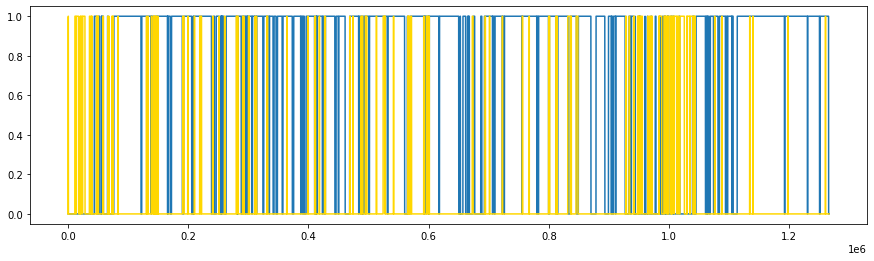

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))
plt.plot(result.index, result['ADULT'])
plt.plot(result.index, result['CHILD'], color='gold')
plt.show()

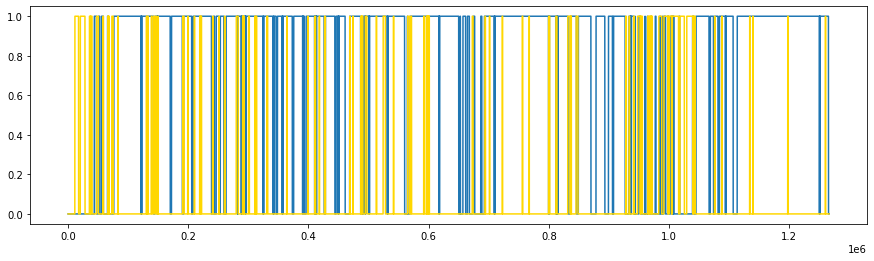

In [30]:
plt.figure(figsize=(15, 4))
plt.plot(result.index, result['SMOOTH_A'])
plt.plot(result.index, result['SMOOTH_C'], color='gold')
plt.show()

In [31]:
# Write output to CSV.
#result.to_csv('./TestData/eNY-0287.csv')

## TeacherPrint Data

In [32]:
def convert(n): 
    return time.strftime("%M min %S sec", time.gmtime(n))

### Summary

In [33]:
# Calculate the total time (sec).
tp_time = round(len(result.index)*.001,1)
print("TOTAL LESSON TIME: " + convert(tp_time)) 

TOTAL LESSON TIME: 21 min 06 sec


### Talk Time
#### Raw

In [34]:
# Calculate total talktime (sec).
tp_tt = round(((result['ADULT'].sum() + result['CHILD'].sum())*.001), 1)
print("TOTAL TALK TIME: " + convert(tp_tt)) 

# Calculate teacher talktime (sec and %).
tp_att = round(result['ADULT'].sum()*.001, 1)
tp_att_pc = int(round((tp_att/tp_tt)*100, 0))
print(tp_att, tp_att_pc)

# Calculate student talktime (sec and %).
tp_ctt = round(result['CHILD'].sum()*.001, 1)
tp_ctt_pc = int(round((tp_ctt/tp_tt)*100, 0))
print(tp_ctt, tp_ctt_pc)

print('During your lesson you spoke ' 
      + str(tp_att_pc) + '% of the time and the Students spoke ' 
      + str(tp_ctt_pc) + '% of the time.')

# Calculate the Talk Time metric ("For every second...".
tp_tt_metric = int(round(tp_att/tp_ctt, 0))

print('For every second of Student talk time, there were about ' 
      + str(tp_tt_metric) + ' seconds of Teacher talk time.')

TOTAL TALK TIME: 17 min 45 sec
937.2 88
128.1 12
During your lesson you spoke 88% of the time and the Students spoke 12% of the time.
For every second of Student talk time, there were about 7 seconds of Teacher talk time.


#### Smoothed
Pauses of one second or less between consecutive statements are smoothed out.

In [35]:
# Calculate total smoothed talktime (sec).
tp_tt_s = round(((result['SMOOTH_A'].sum() + result['SMOOTH_C'].sum())*.001), 1)
print("TOTAL TALK TIME: " + convert(tp_tt_s)) 

# Calculate teacher talktime (sec and %).
tp_att_s = round(result['SMOOTH_A'].sum()*.001, 1)
tp_att_pc_s = int(round((tp_att_s/tp_tt_s)*100, 0))
print(tp_att_s, tp_att_pc_s)

# Calculate student talktime (sec and %).
tp_ctt_s = round(result['SMOOTH_C'].sum()*.001, 1)
tp_ctt_pc_s = int(round((tp_ctt_s/tp_tt_s)*100, 0))
print(tp_ctt_s, tp_ctt_pc_s)

print('During your lesson you spoke ' 
      + str(tp_att_pc_s) + '% of the time and the Students spoke ' 
      + str(tp_ctt_pc_s) + '% of the time.')

# Calculate the Talk Time metric ("For every second...".
tp_tt_metric_s = int(round(tp_att_s/tp_ctt_s, 0))

print('For every second of Student talk time, there were about ' 
      + str(tp_tt_metric_s) + ' seconds of Teacher talk time.')

TOTAL TALK TIME: 18 min 45 sec
973.4 87
151.7 13
During your lesson you spoke 87% of the time and the Students spoke 13% of the time.
For every second of Student talk time, there were about 6 seconds of Teacher talk time.


### Statements
#### Raw

In [45]:
#Calculate number of statements.
tp_utt_a = result['UTT_A'].value_counts()[1]
tp_utt_c = result['UTT_C'].value_counts()[1]
tp_utt = tp_utt_a + tp_utt_c
print("TOTAL STATMENTS: " + str(tp_utt)) 
print(tp_utt_a, tp_utt_c)

# Calculate average statement length.
tp_uttlen_a = round((tp_att/tp_utt_a), 1)
tp_uttlen_c = round((tp_ctt/tp_utt_c), 1)

print('Your average statement was ' 
      + str(tp_uttlen_a) + ' seconds long, while the average Student statement was ' 
      + str(tp_uttlen_c) + ' seconds long.')

# Calculate the Statement metric ("For every second...".
tp_utt_metric = int(round(tp_uttlen_a/tp_uttlen_c, 0))

print('For every second of Student statements, there were about ' 
      + str(tp_utt_metric) + ' seconds of Teacher statements.')

TOTAL STATMENTS: 234
120 114
7.8
1.1
Your average statement was 7.8 seconds long, while the average Student statement was 1.1 seconds long.
For every second of Student statements, there were about 7 seconds of Teacher statements.


#### Smoothed
Pauses of one second or less between consecutive statements are smoothed out.

In [46]:
#Calculate number of smoothed statements.
tp_utt_a_s = result['SMOOTH_UTT_A'].value_counts()[1]
tp_utt_c_s = result['SMOOTH_UTT_C'].value_counts()[1]
tp_utt_s = tp_utt_a_s + tp_utt_c_s
print("TOTAL STATMENTS: " + str(tp_utt_s)) 
print(tp_utt_a_s, tp_utt_c_s)

# Calculate average smoothed statement length.
tp_uttlen_a_s = round((tp_att_s/tp_utt_a_s), 1)
tp_uttlen_c_s = round((tp_ctt_s/tp_utt_c_s), 1)

print('Your average statement was ' 
      + str(tp_uttlen_a_s) + ' seconds long, while the average Student statement was ' 
      + str(tp_uttlen_c_s) + ' seconds long.')


# Calculate the Statement metric ("For every second...".
tp_utt_metric_s = int(round(tp_uttlen_a_s/tp_uttlen_c_s, 0))

print('For every second of Student statements, there were about ' 
      + str(tp_utt_metric_s) + ' seconds of Teacher statements.')

TOTAL STATMENTS: 200
102 98
Your average statement was 9.5 seconds long, while the average Student statement was 1.5 seconds long.
For every second of Student statements, there were about 6 seconds of Teacher statements.


### Pauses

#### Raw

In [47]:
# Calculate pause time (sec).
tp_pt = round(result['PAUSE'].sum()*.001, 1)
tp_pt_avg = (round((tp_pt/tp_utt), 1))
print("TOTAL PAUSE TIME: " + convert(tp_pt)) 
print("AVERAGE PAUSE TIME: " + convert(tp_pt_avg)) 

#Calculate number of pauses.
tp_pause_a = result['UTT_A'].value_counts()[-1]
tp_pause_a_avg = (round((tp_pause_a/tp_utt_a), 1))
print(tp_pause_a, tp_pause_a_avg)

tp_pause_c = result['UTT_C'].value_counts()[-1]
tp_pause_c_avg = (round((tp_pause_c/tp_utt_c), 1))
print(tp_pause_c, tp_pause_c_avg)

tp_pause_c = result['UTT_S'].value_counts()[-1]
tp_pause_pc = int(round((tp_pause_c/tp_utt)*100, 0))
print(tp_pause_c, tp_pause_pc)

print('On average, the Students waited ' +
      str(tp_pause_a_avg) + ' seconds after you stopped speaking to begin their turn. You typically waited ' +
      str(tp_pause_c_avg) + ' seconds to speak after the Students stopped.')

print('In this lesson, ' + str(tp_pause_pc) 
      + '% of Statements had pauses between them.')

TOTAL PAUSE TIME: 03 min 57 sec
AVERAGE PAUSE TIME: 00 min 01 sec
120 1.0
114 1.0
156 67
On average, the Students waited 1.0 seconds after you stopped speaking to begin their turn. You typically waited 1.0 seconds to speak after the Students stopped.
In this lesson, 67% of Statements had pauses between them.


#### Smoothed

In [48]:
# Calculate pause time (sec).
tp_pt_s = round(result['SMOOTH_PAUSE'].sum()*.001, 1)
tp_pt_avg_s = (round((tp_pt_s/tp_utt_s), 1))
print("TOTAL PAUSE TIME: " + convert(tp_pt_s)) 
print("AVERAGE PAUSE TIME: " + convert(tp_pt_avg_s)) 

#Calculate number of pauses.
tp_pause_a_s = result['SMOOTH_UTT_A'].value_counts()[-1]
tp_pause_a_avg_s = (round((tp_pause_a_s/tp_utt_a_s), 1))
print(tp_pause_a_s, tp_pause_a_avg_s)

tp_pause_c_s = result['SMOOTH_UTT_C'].value_counts()[-1]
tp_pause_c_avg_s = (round((tp_pause_c_s/tp_utt_c_s), 1))
print(tp_pause_c_s, tp_pause_c_avg_s)

tp_pause_s = result['SMOOTH_UTT_S'].value_counts()[-1]
tp_pause_pc_s = int(round((tp_pause_s/tp_utt_s)*100, 0))
print(tp_pause_s, tp_pause_pc)

print('On average, the Students waited ' +
      str(tp_pause_a_avg_s) + ' seconds after you stopped speaking to begin their turn. You typically waited ' +
      str(tp_pause_c_avg_s) + ' seconds to speak after the Students stopped.')

print('In this lesson, ' + str(tp_pause_pc_s) 
      + '% of Statements had pauses between them.')

TOTAL PAUSE TIME: 03 min 14 sec
AVERAGE PAUSE TIME: 00 min 01 sec
102 1.0
98 1.0
116 67
On average, the Students waited 1.0 seconds after you stopped speaking to begin their turn. You typically waited 1.0 seconds to speak after the Students stopped.
In this lesson, 58% of Statements had pauses between them.


### Overlaps
Still need to figure out directionality.

#### Raw

In [59]:
# Calculate overlap time (sec).
tp_ot = round(result['OVERLAP'].sum()*.001, 1)
print("TOTAL OVERLAP TIME: " + convert(tp_ot)) 

tp_overlap_pc = 100 - tp_pause_pc
tp_ot_avg = round(tp_ot/(tp_overlap_pc*tp_utt), 3)

print('The average overlap was about ' + str(tp_ot_avg) + ' seconds.')

print('In this lesson ' + str(tp_overlap_pc) 
      + '% of Statements had overlaps between them.')

TOTAL OVERLAP TIME: 00 min 36 sec
The average overlap was about 0.005 seconds.
In this lesson 33% of Statements had overlaps between them.


#### Smoothed

In [60]:
# Calculate smoothed overlap time (sec).
tp_ot_s = round(result['SMOOTH_OVERLAP'].sum()*.001, 1)
print("TOTAL OVERLAP TIME: " + convert(tp_ot_s)) 

tp_overlap_pc_s = 100 - tp_pause_pc_s
tp_ot_avg_s = round(tp_ot_s/(tp_overlap_pc_s*tp_utt_s), 3)

print('The average overlap was about ' + str(tp_ot_avg_s) + ' seconds.')

print('In this lesson ' + str(tp_overlap_pc_s) 
      + '% of Statements had overlaps between them.')

TOTAL OVERLAP TIME: 00 min 53 sec
The average overlap was about 0.006 seconds.
In this lesson 42% of Statements had overlaps between them.


### Speaker Wheel
#### Raw

In [42]:
# Calculate Speaker Wheel input values (percent).
sw_adult = int(round((tp_att-tp_ot)/tp_time*100))
sw_overlap = int(round(tp_ot/tp_time*100))
sw_child = int(round((tp_ctt-tp_ot)/tp_time*100))
sw_pause = int(round(tp_pt/tp_time*100))
sw_df = {"TEACHER": sw_adult, "OVERLAPS": sw_overlap, "STUDENT": sw_child, "PAUSES": sw_pause}
sw_df

{'TEACHER': 71, 'OVERLAPS': 3, 'STUDENT': 7, 'PAUSES': 19}

#### Smoothed
Pauses of one second or less between consecutive statements are smoothed out.

In [43]:
# Calculate Speaker Wheel input values (percent) based on smoothed data.
sw_adult_s = int(round((tp_att_s-tp_ot_s)/tp_time*100))
sw_overlap_s = int(round(tp_ot_s/tp_time*100))
sw_child_s = int(round((tp_ctt_s-tp_ot_s)/tp_time*100))
sw_pause_s = int(round(tp_pt_s/tp_time*100))
sw_df_s = {"TEACHER": sw_adult, "OVERLAPS": sw_overlap, "STUDENT": sw_child, "PAUSES": sw_pause}
sw_df_s

{'TEACHER': 71, 'OVERLAPS': 3, 'STUDENT': 7, 'PAUSES': 19}